# Performance evolution of the simdjson library

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
from statsmodels.formula.api import ols
from numpy import log, mean, std

warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start'] = pandas.to_datetime(res['start'])
    res['stop'] = pandas.to_datetime(res['stop'])
    res['timestamp'] = res['start'] - res['start'].min()
    info = get_yaml(name, 'info.yaml')
    res['cluster'] = info['cluster']
    res['expfile'] = info['expfile'][0]
    installfile = info['installfile']
    installfile = get_yaml(name, installfile)
    res['version'] = installfile['version']
    res['global_id'] = -1
    nb_calls = installfile['nb_runs']*installfile['nb_calls']
    for host in res['hostname'].unique():
        res.loc[res['hostname'] == host, 'global_id'] = range(nb_calls)
    res['run_id'] = res['global_id'] // installfile['nb_calls']
    res['call_id'] = res['global_id'] % installfile['nb_calls']
    return res

directory = '2/'
all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.zip')]

df = pandas.concat([read_result(f) for f in all_files])
df.head()

,hostname,duration,gigabytes_per_second,start,stop,filename,timestamp,cluster,expfile,version,global_id,run_id,call_id
0,parasilo-11.rennes.grid5000.fr,0.008614,0.733115,2020-05-09 18:10:20.301677,2020-05-09 18:10:20.404881,2/rennes_2020-05-09_1267516.zip,0 days,parasilo,twitter10.json,76314280cb3f31894e107caadd5eb1650a7a6a44,0,0,0
1,parasilo-11.rennes.grid5000.fr,0.005485,1.151330,2020-05-09 18:10:20.301677,2020-05-09 18:10:20.404881,2/rennes_2020-05-09_1267516.zip,0 days,parasilo,twitter10.json,76314280cb3f31894e107caadd5eb1650a7a6a44,1,0,1
2,parasilo-11.rennes.grid5000.fr,0.004175,1.512439,2020-05-09 18:10:20.301677,2020-05-09 18:10:20.404881,2/rennes_2020-05-09_1267516.zip,0 days,parasilo,twitter10.json,76314280cb3f31894e107caadd5eb1650a7a6a44,2,0,2
3,parasilo-11.rennes.grid5000.fr,0.003995,1.580816,2020-05-09 18:10:20.301677,2020-05-09 18:10:20.404881,2/rennes_2020-05-09_1267516.zip,0 days,parasilo,twitter10.json,76314280cb3f31894e107caadd5eb1650a7a6a44,3,0,3
4,parasilo-11.rennes.grid5000.fr,0.003984,1.585038,2020-05-09 18:10:20.301677,2020-05-09 18:10:20.404881,2/rennes_2020-05-09_1267516.zip,0 days,parasilo,twitter10.json,76314280cb3f31894e107caadd5eb1650a7a6a44,4,0,4


In [2]:
versions = {
    '3c3a4db54e1775de6e1946e66d7524f2f38aa02a': '2020-05-06 23:08:10',
    '76314280cb3f31894e107caadd5eb1650a7a6a44': '2020-04-25 11:24:41',
    '1ff22c78b3f5111b865664d278981f5537129497': '2020-04-09 14:56:54',
    'e04cbd71d097ad8f8bb3316b7fb1875568c9d13c': '2020-05-02 01:44:11',
    'ff09b6c82494af6dbe42fa3a218ed86f15dc8666': '2020-04-17 12:23:05',
    'v0.3.1': '2020-04-02 19:24:43',
}

versions = {v: pandas.to_datetime(d) for v, d in versions.items()}
df['version_date'] = df.apply(lambda row: versions[row['version']], axis=1)

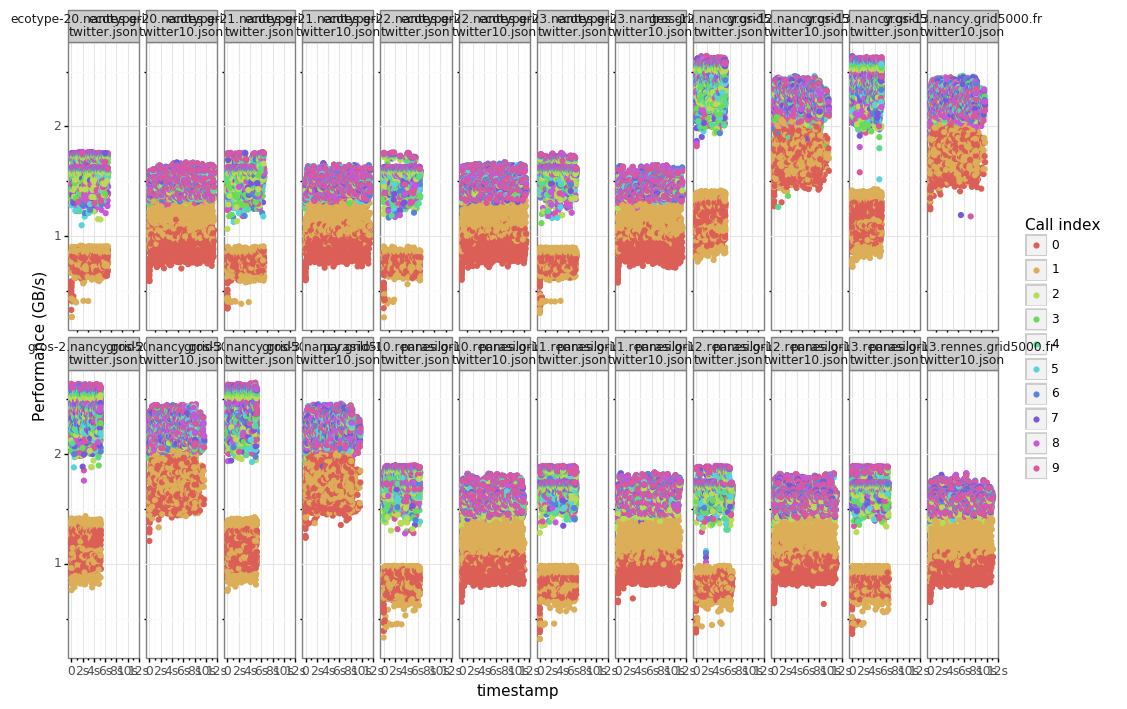

<ggplot: (8733285985677)>

In [3]:
ggplot(df) +\
    aes(x='timestamp', y='gigabytes_per_second', color='factor(call_id)') +\
    geom_point() +\
    facet_wrap(['hostname', 'expfile'], nrow=2) +\
    ylab('Performance (GB/s)') +\
    labs(color='Call index') +\
    theme_bw()

Alright, let's remove the first two calls for each run.

In [4]:
df = df[df['call_id'] > 1]

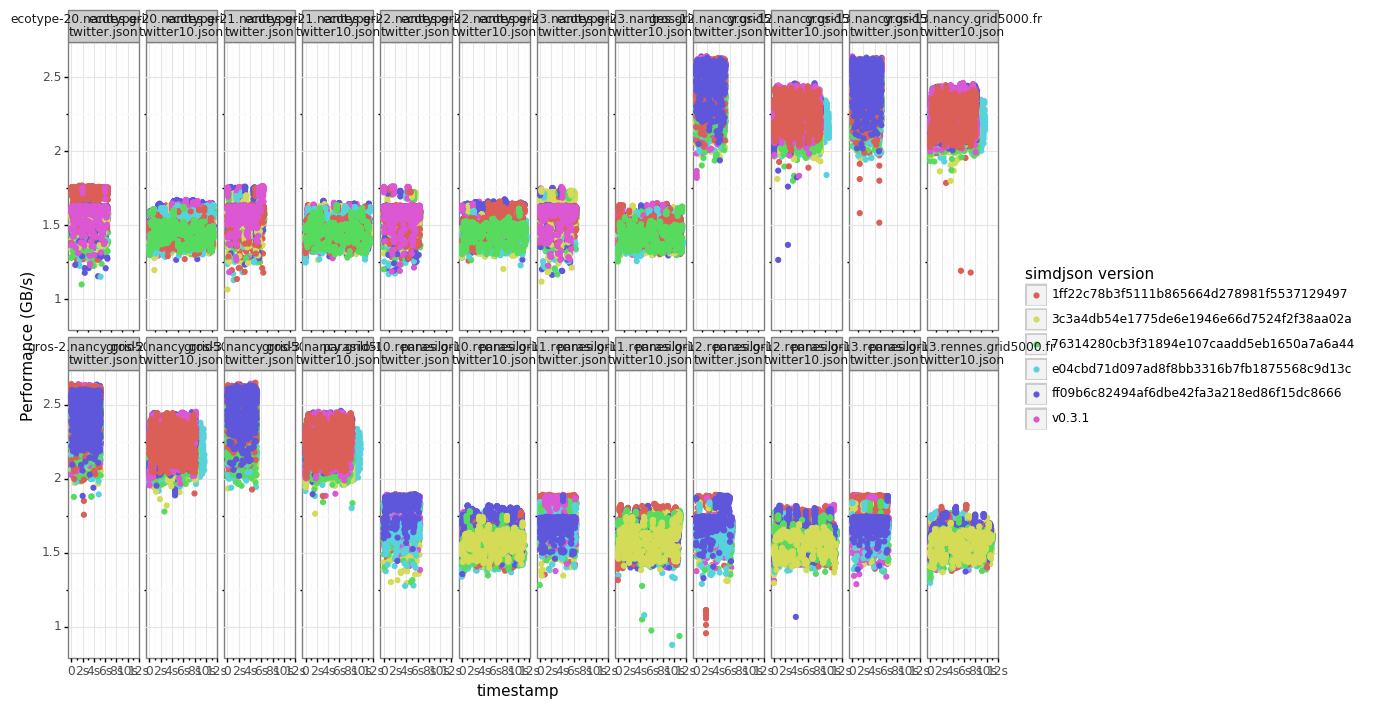

<ggplot: (8733177689527)>

In [5]:
ggplot(df) +\
    aes(x='timestamp', y='gigabytes_per_second', color='version') +\
    geom_point() +\
    facet_wrap(['hostname', 'expfile'], nrow=2) +\
    ylab('Performance (GB/s)') +\
    labs(color='simdjson version') +\
    theme_bw()

(0.8769829829663021, 2.6496058201835173)


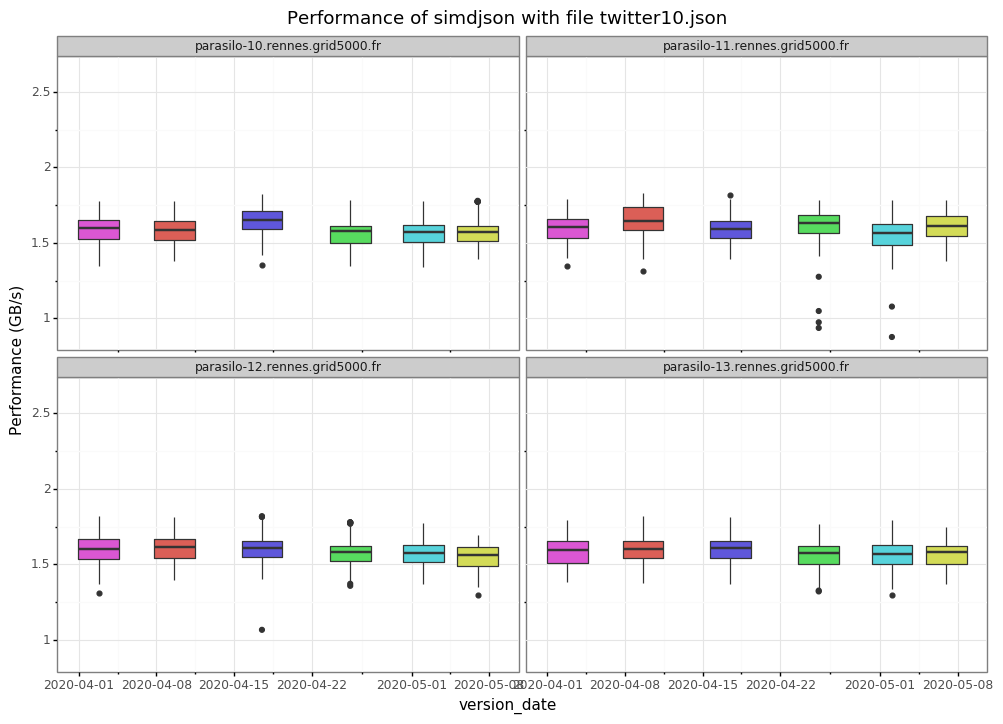

<ggplot: (8733173268793)>


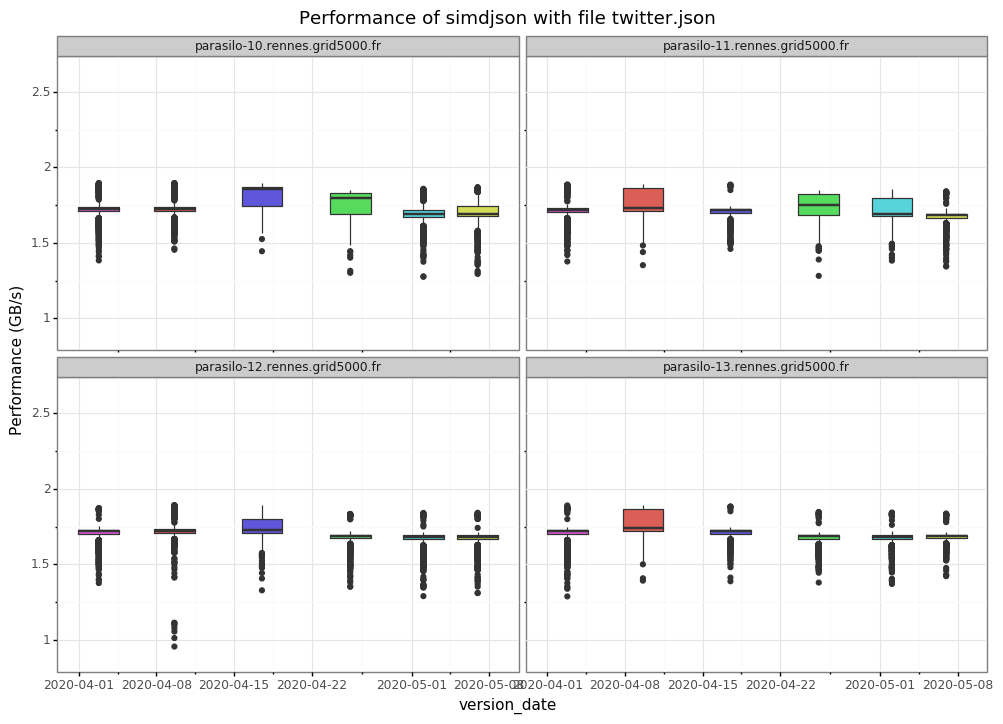

<ggplot: (8733173094099)>


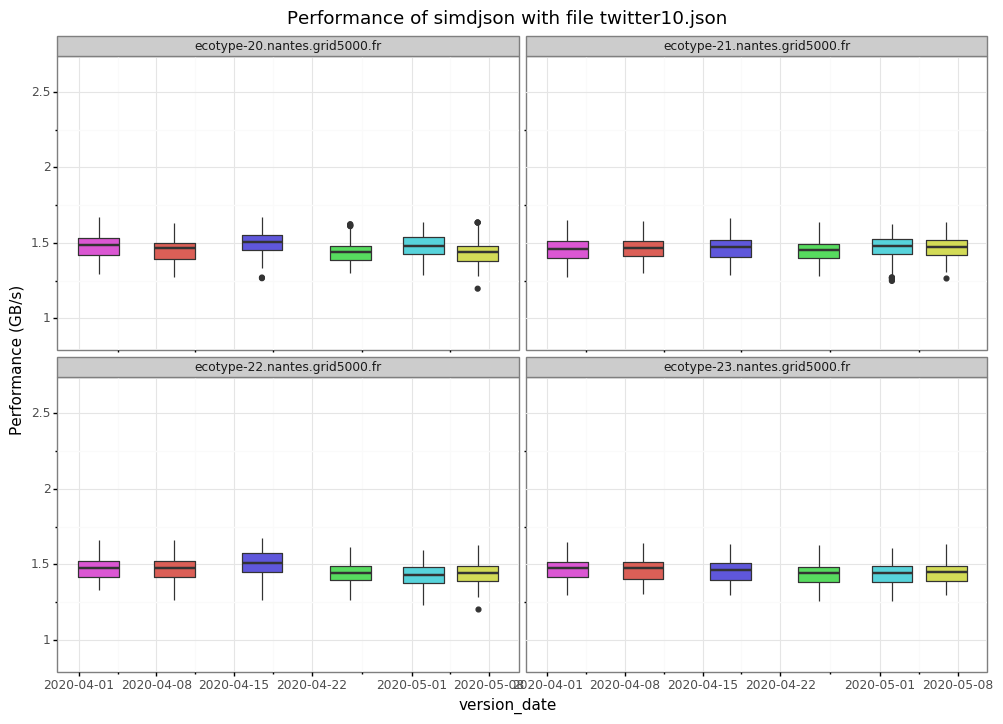

<ggplot: (8733172875468)>


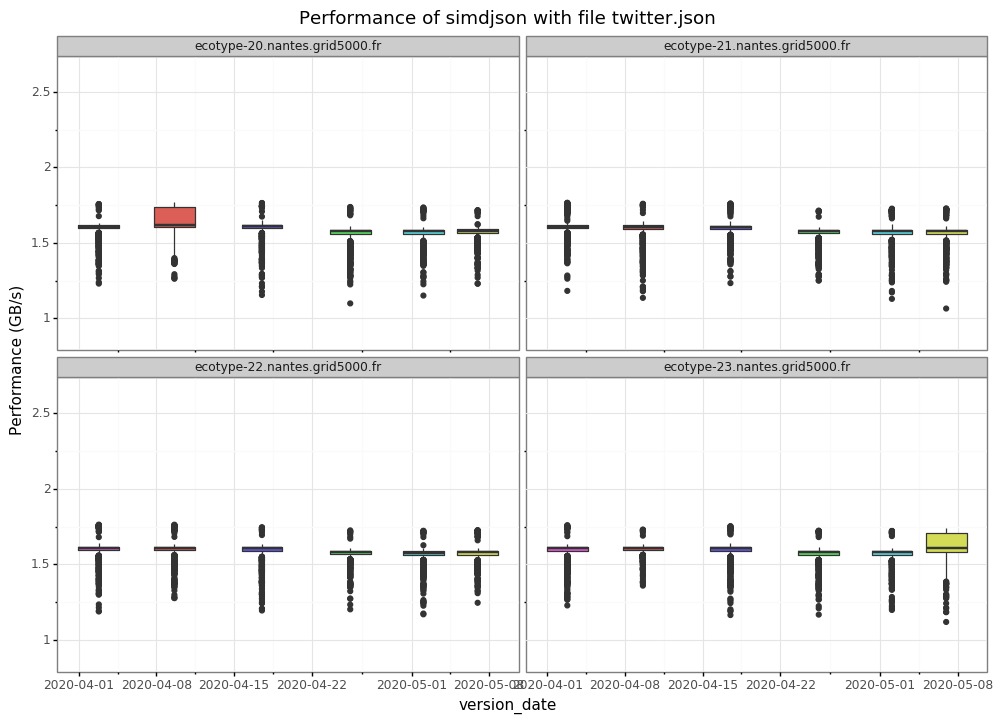

<ggplot: (8733173089228)>


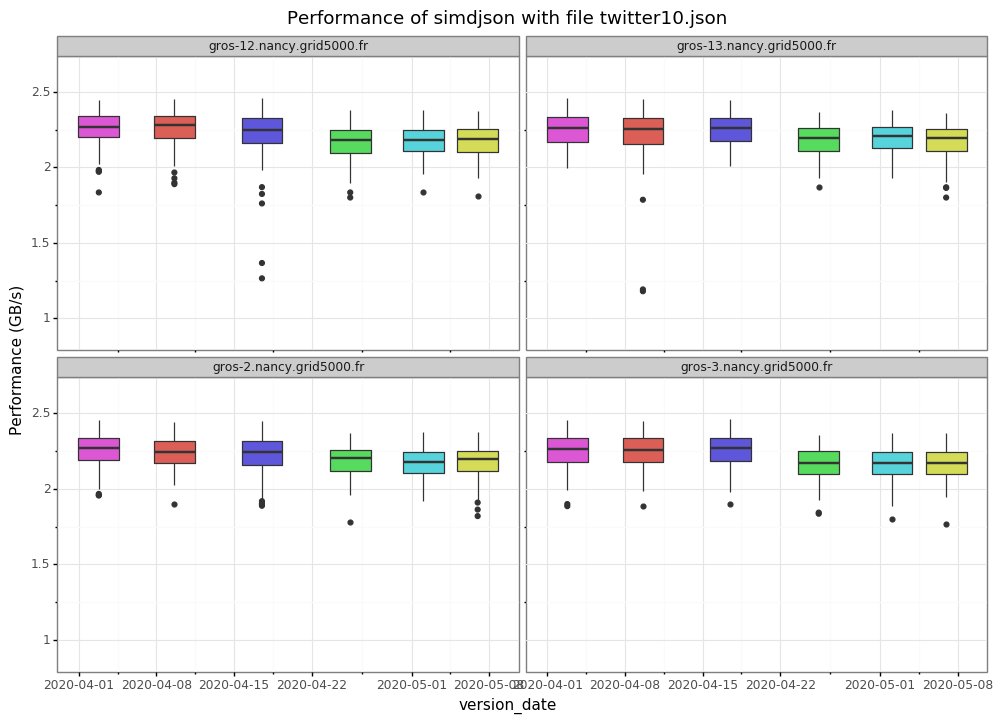

<ggplot: (-9223363303669579467)>


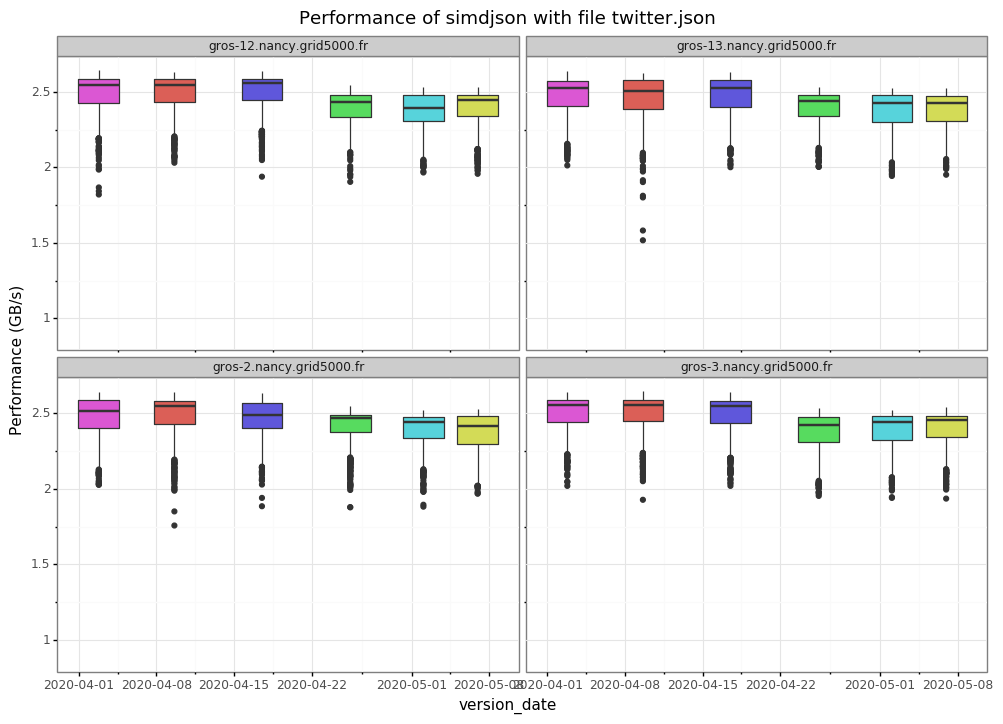

<ggplot: (8733184268310)>


In [6]:
ycol = 'gigabytes_per_second'
minmax = (df[ycol].min(), df[ycol].max())
print(minmax)

for cluster in df['cluster'].unique():
    for expfile in df['expfile'].unique():
        plot = ggplot(df[(df['cluster'] == cluster) & (df['expfile'] == expfile)]) +\
            aes(x='version_date', y=ycol, fill='version') +\
            geom_boxplot() +\
            facet_wrap('hostname', nrow=2) +\
            theme_bw() +\
            expand_limits(y=minmax) +\
            ylab('Performance (GB/s)') +\
            labs(fill='simdjson version') +\
            theme(legend_position='none') +\
            ggtitle(f'Performance of simdjson with file {expfile}')
        print(plot)